# K-MEDIAS VS DBSCAN

En esta práctica se comparará para 2 casos en particular qué tan efectivos son los algoritmos de clustering K-Medias (o K-Means en inglés) y DBSCAN.

In [1]:
#Importamos las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 12]
np.random.seed(42)

In [2]:
from sklearn.datasets import make_blobs

El módulo "make_blobs" sirve para generar puntos aleatorios en forma de burbujas. Generaremos 5000 puntos aleatorios distrubuidos en 3 burbujas.

In [3]:
n_muestras = 5000

centroides = [(24, 30), (52, 35), (35, 60)]
X, clases_reales = make_blobs(n_samples=n_muestras, n_features=2, cluster_std=5.0,
                  centers=centroides, shuffle=False, random_state=42)

In [4]:
# Vemos la forma
X.shape

(5000, 2)

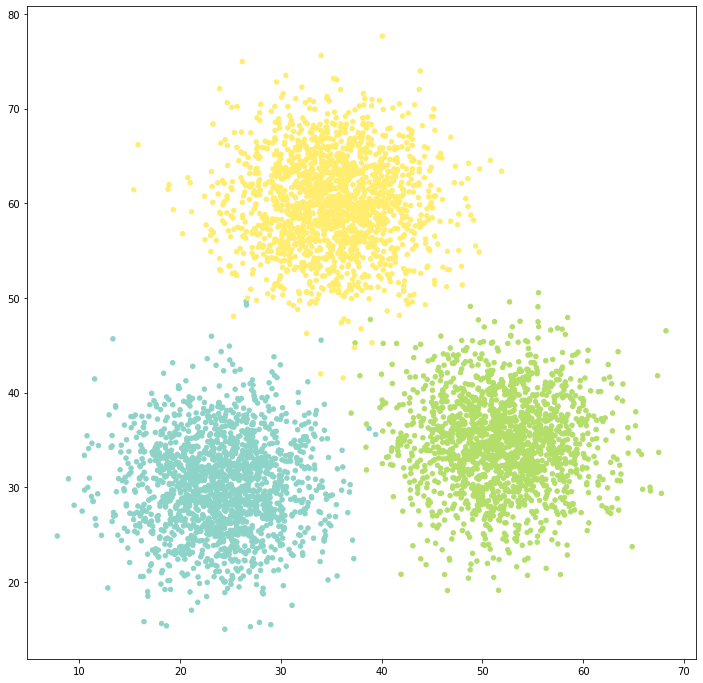

In [5]:
# Graficamos
from matplotlib  import cm

plt.scatter(X[:,0],X[:,1],c=clases_reales,s=20, marker = 'o', cmap=cm.Set3);

In [6]:
# Importamos los módulos de K-Medias y DBSCAN

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure

In [7]:
# Hacemos el modelo y el ajuste
estimador_kmedias = KMeans(n_clusters=3)
etiquetas_kmedias = estimador_kmedias.fit(X).labels_

Text(0.5, 1.0, 'Clusters producidos con KMedias')

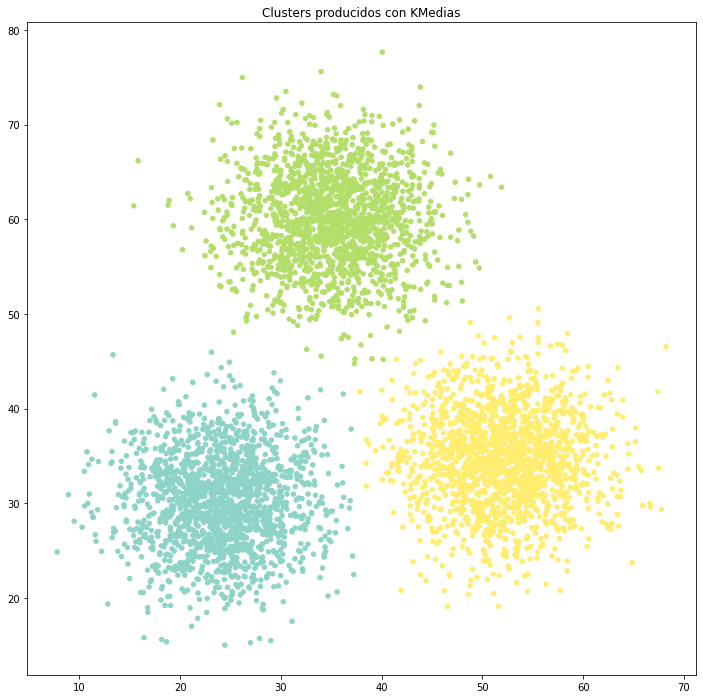

In [8]:
# Graficamos
plt.scatter(X[:,0],X[:,1], c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.title("Clusters producidos con KMedias")

Dado que en este ejemplo, tenemos las clases verdaderas (ya que hemos generado el dataset de forma artificial), vamos a hacer unas funciones auxiliares que nos ayuden a mostrar de forma clara aquellos puntos que se clasifican de forma incorrecta.

En primer lugar, creamos una función que nos calcule el Índice de Jaccard de dos grupos de puntos (definido como el número de elementos comunes a los dos grupos (intersección) de los dos grupos dividida por el número de elementos en cualquiera de los dos grupos (la unión).

In [9]:
def jaccard_index(cluster1, cluster2):
    intersection = np.intersect1d(cluster1, cluster2).shape[0]
    union = np.union1d(cluster1, cluster2).shape[0]
    return intersection / union

In [10]:
jaccard_index(X[clases_reales==0], X[etiquetas_kmedias==0])

0.9952095808383233

Ahora hacemos una funcion, que dado un conjunto de clases y clusters, nos diga que cluster se corresponde a cada clase. Esto es necesario ya que los nombres que da el estimador de clustering no tienen por qué coincidir con las clases reales (es decir, la clase 0 no tiene que representar al mismo número de puntos que el cluster 0).

In [11]:
from itertools import product

In [12]:
list(product([1,2],[3,4]))

[(1, 3), (1, 4), (2, 3), (2, 4)]

In [13]:
def emparejar_clusters_clases(clusters, clases):
    combinaciones = product(np.unique(clases), np.unique(clusters))
    emparejamientos = {}
    class_ids = np.unique(clases)
    cluster_ids = np.unique(clusters)
    for cluster_id in cluster_ids:
        old_jaccard = 0
        for class_id in class_ids:
            new_jaccard = jaccard_index(X[clases==class_id], X[clusters==cluster_id])
            if new_jaccard > old_jaccard:
                old_jaccard = new_jaccard
                emparejamientos[cluster_id] = class_id
                if new_jaccard>=0.5:
                    break
    return emparejamientos

In [14]:
emparejar_clusters_clases(etiquetas_kmedias, clases_reales)

{0: 0, 1: 2, 2: 1}

De esta forma, podemos observar que el cluster 0 corresponde con el 0, el cluster 1 corresponde con el 2 y el cluster 2 corresponde con el 1.

Con estas funciones podemos crear una función auxiliar que nos transforma unas etiquetas de cluster para que se correspondan con las clases reales, y una función que nos devuelva aquellas observaciones cuya clase no coincida con el cluster

In [15]:
def alinear_clusters(clusters, clases):
    reemplazos = emparejar_clusters_clases(clusters, clases)
    clusters_alineados = [reemplazos[x] for x in clusters]
    return np.array(clusters_alineados)

def encontrar_errores(clusters, clases):
    etiquetas_clusters_alineadas = alinear_clusters(clusters, clases)
    return X[clases!=etiquetas_clusters_alineadas]

Text(0.5, 1.0, 'Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados')

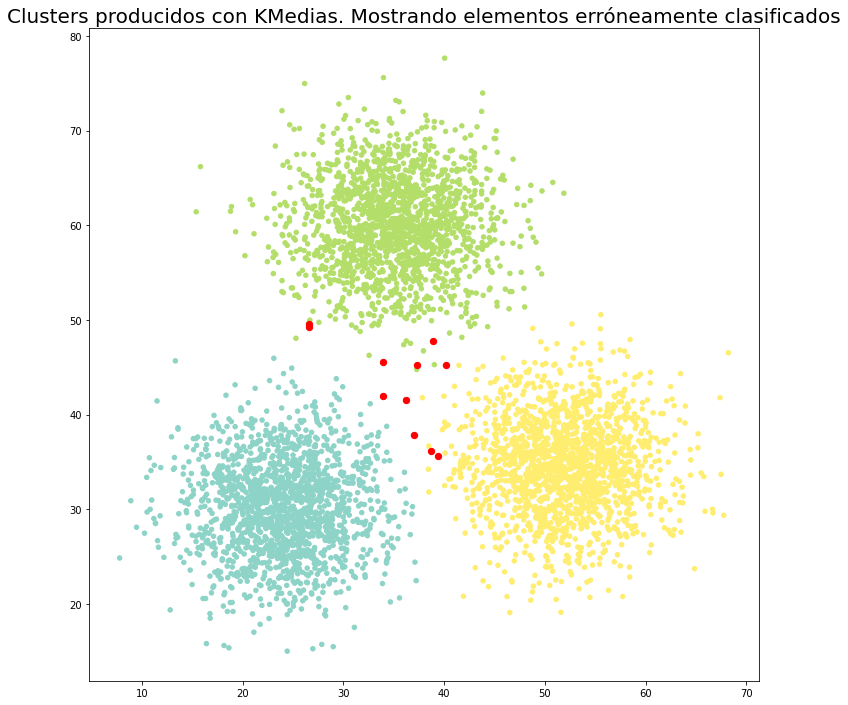

In [16]:
errores_kmedias = encontrar_errores(etiquetas_kmedias, clases_reales)
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.scatter(errores_kmedias[:,0],errores_kmedias[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados", size=20)

In [17]:
# Evaluamos la silueta
silhouette_score(X, etiquetas_kmedias)

0.6801855780824735

In [18]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_kmedias)

(0.9848477175260212, 0.9848485778151884, 0.984848147670417)

Ahora evaluamos con DBSCAN, es difícil comparar resultados con KMedias dado que en KMedias se especifica el número de clusters y en DBSCAN se especifica la densidad de los mismos

In [19]:
estimador_dbscan = DBSCAN(eps=10, min_samples=1000)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_

In [20]:
np.unique(etiquetas_dbscan)

array([-1,  0,  1,  2], dtype=int64)

Text(0.5, 1.0, 'Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados')

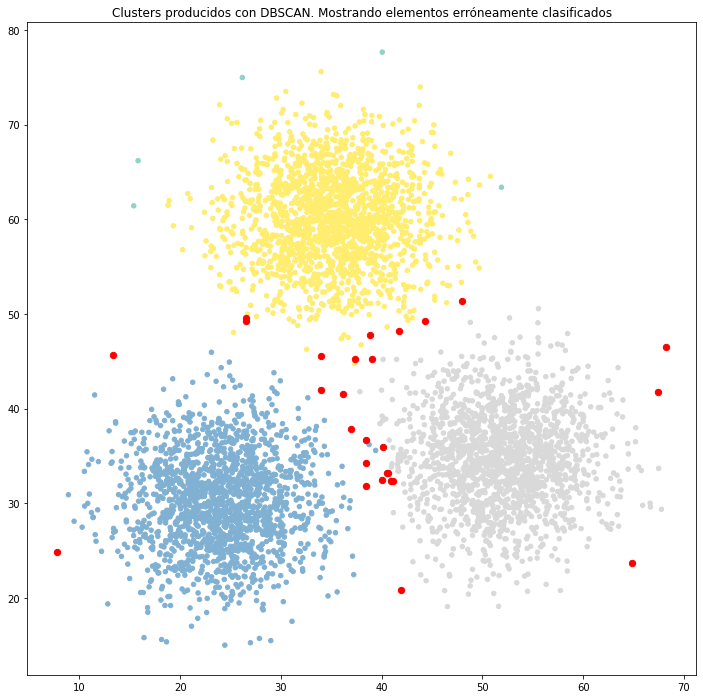

In [21]:
plt.scatter(X[:,0],X[:,1],c=etiquetas_dbscan,s=20, marker = 'o', cmap=cm.Set3)
errores_dbscan = encontrar_errores(etiquetas_dbscan, clases_reales)
plt.scatter(errores_dbscan[:,0],errores_dbscan[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados")

In [22]:
# Evaluamos la silueta
silhouette_score(X, etiquetas_dbscan)

0.6723834492118366

In [23]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_dbscan)

(0.9720560210205188, 0.9604880908580997, 0.9662374339590347)

Vemos que para el caso de tres clusters claramente definidos, KMedias funciona ligeramente mejor que DBSCAN.
Probamos ahora con una distribución de datos que no sean tan fáciles de separar en grupos basándose en criterios geométricos.

In [24]:
from sklearn.datasets import make_circles

El módulo "make_circles" se utiliza para generar puntos aleatorios en forma de circunferencias. Generaremos de nuevo 5000 puntos aleatorios en forma de 2 circunferencias concéntricas.

In [25]:
X, clases_reales = make_circles(n_samples=5000, factor=.3, noise=.05)

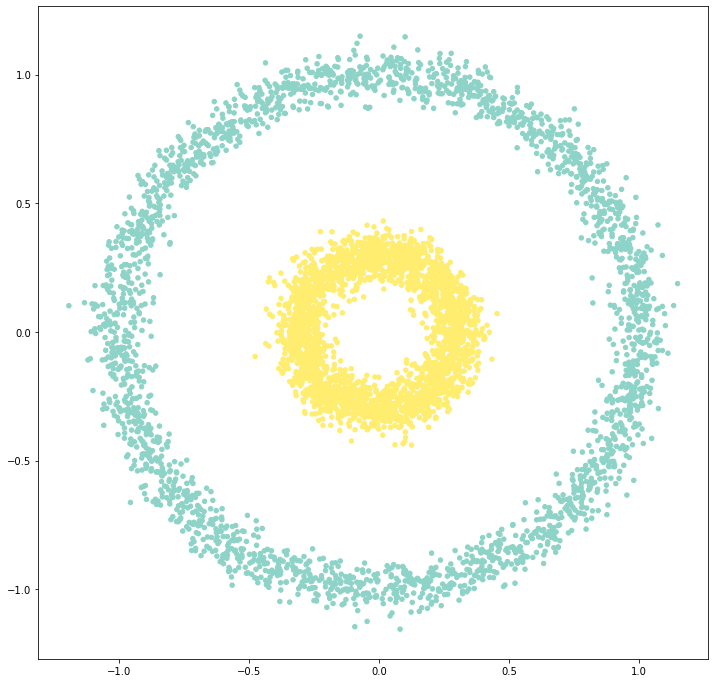

In [26]:
# Graficamos
plt.scatter(X[:,0],X[:,1],c=clases_reales,s=20, marker = 'o', cmap=cm.Set3);

In [27]:
# Creamos el modelo y hacemos el ajuste
estimador_kmedias = KMeans(n_clusters=2)
etiquetas_kmedias = estimador_kmedias.fit(X).labels_

Text(0.5, 1.0, 'Clusters producidos con KMedias')

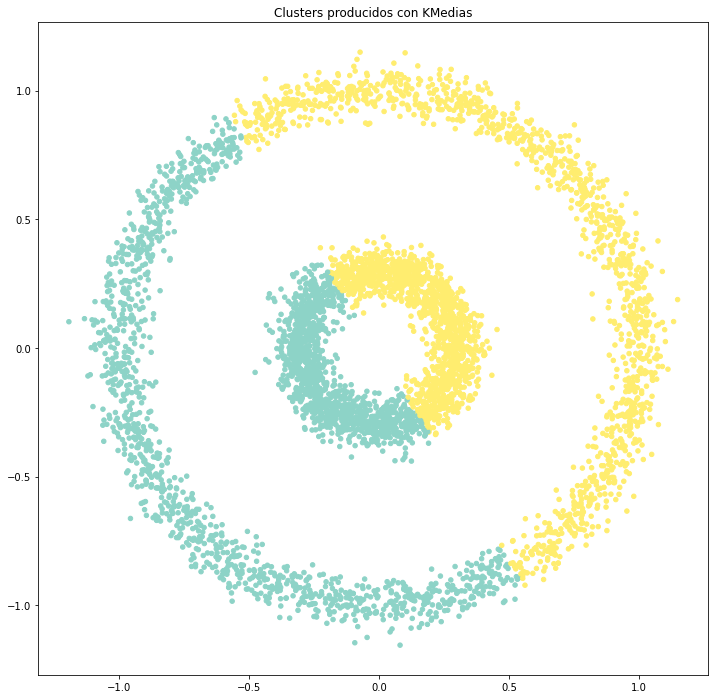

In [28]:
# Graficamos
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.title("Clusters producidos con KMedias")

Vemos que al basarse en el criterio de cercania al centroide, y dado que ambos clases tienen el mismo centroide, el algoritmo KMedias funciona de forma bastante mediocre, por no decir catastrófica.

Text(0.5, 1.0, 'Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados')

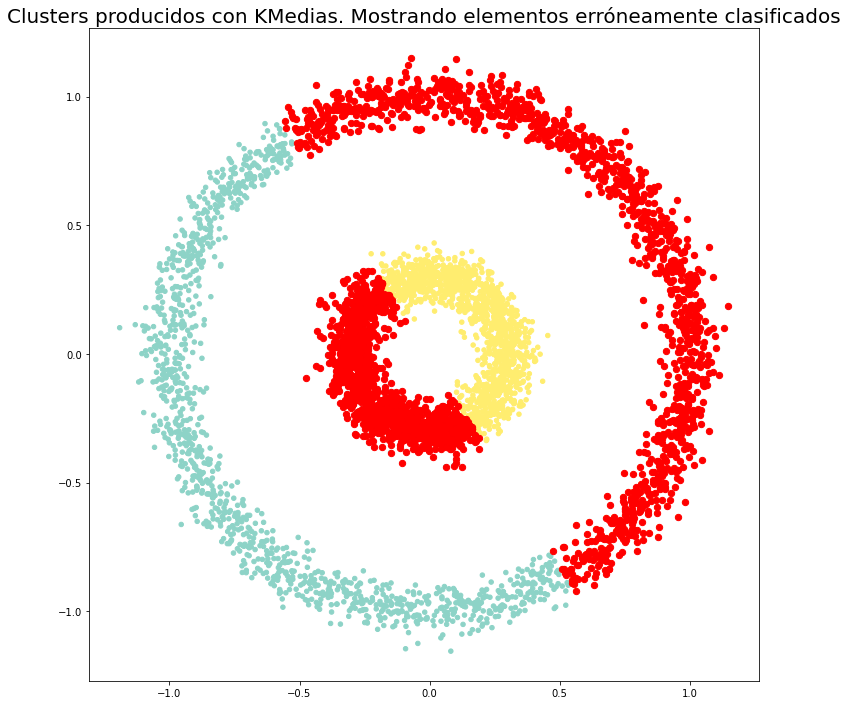

In [29]:
# Graficamos los puntos en los que se equivocó el algoritmo

errores_kmedias = encontrar_errores(etiquetas_kmedias, clases_reales)
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.scatter(errores_kmedias[:,0],errores_kmedias[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados", size=20)

Vemos que KMedias agrupa de forma incorrecta la mitad de los puntos.

In [30]:
# Evaluamos
silhouette_score(X, etiquetas_kmedias)

0.2965424749380652

In [31]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_kmedias)

(7.804653220474846e-05, 7.806397607991157e-05, 7.805525316773585e-05)

Veamos ahora que tal funciona DBSCAN con este dataset.

In [32]:
# Creamos el modelo y hacemos el ajuste
estimador_dbscan = DBSCAN(eps=0.05, min_samples=10)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_

In [33]:
np.unique(etiquetas_dbscan)

array([-1,  0,  1], dtype=int64)

Text(0.5, 1.0, 'Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados')

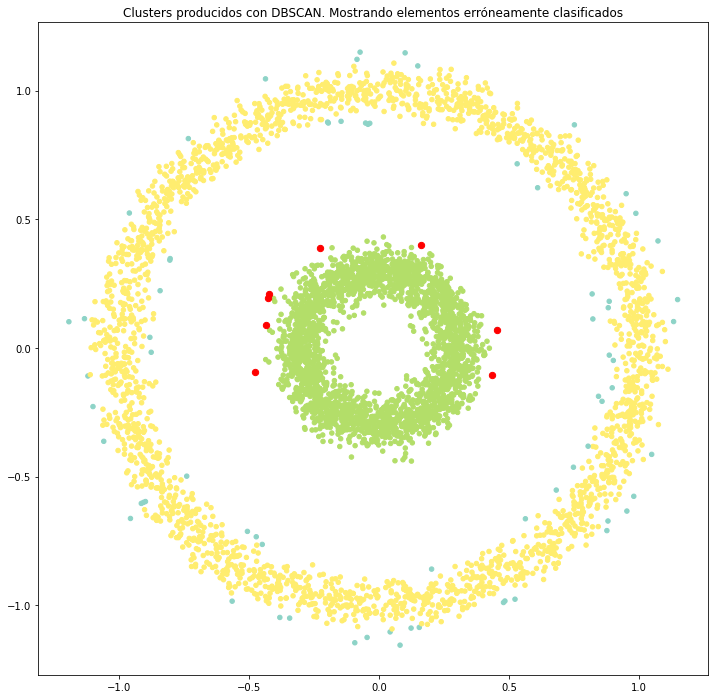

In [34]:
# Graficamos los puntos en los que se equivocó el algoritmo

plt.scatter(X[:,0],X[:,1],c=etiquetas_dbscan,s=20, marker = 'o', cmap=cm.Set3)
errores_dbscan = encontrar_errores(etiquetas_dbscan, clases_reales)
plt.scatter(errores_dbscan[:,0],errores_dbscan[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados")

Vemos que al basarse en un criterio de densidad, DBSCAN encuentra los clusters fácilmente.

In [35]:
# Evaluamos
silhouette_score(X, etiquetas_dbscan)

0.19928594442477718

In [36]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_dbscan)

(0.9925576876229771, 0.9021177335794555, 0.9451791917341158)

En este caso he obtenido los hiperparámetros eps=0.05, min_samples=10 a ojo, iterando sobre el gráfico para ver que valores separaban correctamente las clases reales. En general haríamos una optimización de hiperparámetros para obtener los valores que mejor funcionen.

In [37]:
estimador_dbscan.predict

AttributeError: 'DBSCAN' object has no attribute 'predict'

Una desventaja del estimador DBSCAN en ´sklearn´ es que no tiene el método predict. Es decir, no puede asignar clusters a nuevos puntos sin tener que ajustar el estimador desde cero.